# Chapter: Nonlinear System Identification


## Topic: Polynimial NARX-based Modeling of Heat Exchangers 

In [1]:
# import packages
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf
from matplotlib.ticker import MaxNLocator

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results

# package settings
plt.rcParams.update({'font.size': 14})

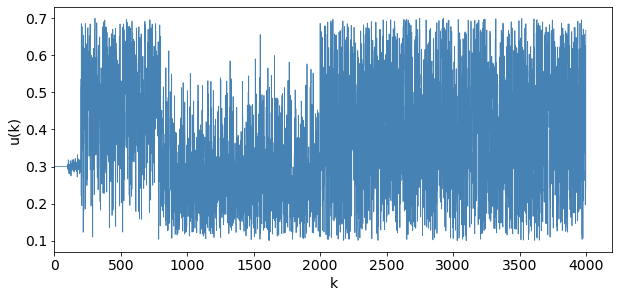

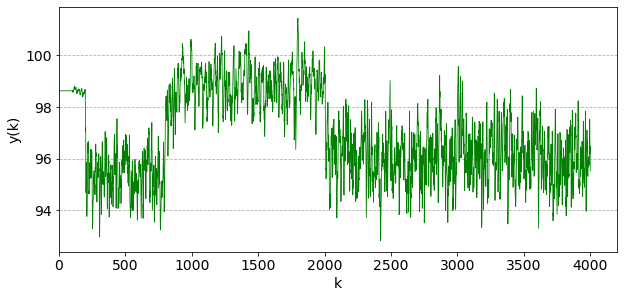

In [2]:
# read data and plot
data = np.loadtxt('exchanger.dat')
u = data[:,1, None]; y = data[:,2, None]

# plots
plt.figure(figsize=(10,4.5))
plt.plot(u, 'steelblue', linewidth=0.8, drawstyle='steps')
plt.ylabel('u(k)'), plt.xlabel('k'), plt.xlim(0)

plt.figure(figsize=(10,4.5))
plt.plot(y, 'g', linewidth=0.8)
plt.ylabel('y(k)'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [3]:
# split into training and test dataset
u_fit = u[:3000,0:1]; u_test = u[3000:,0:1] 
y_fit = y[:3000,0:1]; y_test = y[3000:,0:1] 

In [4]:
# center data before model fitting
u_scaler = StandardScaler(with_std=False); u_fit_centered = u_scaler.fit_transform(u_fit); u_test_centered = u_scaler.transform(u_test) 
y_scaler = StandardScaler(with_std=False); y_fit_centered = y_scaler.fit_transform(y_fit); y_test_centered = y_scaler.transform(y_test)

In [5]:
# fit NARX model
basis_function = Polynomial(degree=2)
model = FROLS(
    order_selection=True,
    n_info_values=75,
    ylag=3, xlag=9,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)

model.fit(X=u_fit_centered, y=y_fit_centered)

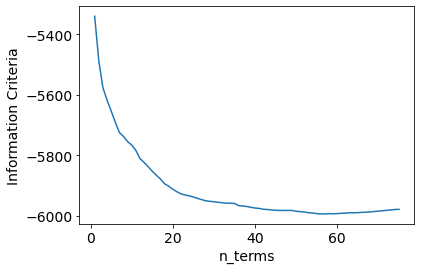

In [7]:
# check AIC values
xaxis = np.arange(1, model.n_info_values + 1)
plt.plot(xaxis, model.info_values)
plt.xlabel('n_terms')
plt.ylabel('Information Criteria')
plt.show()

In [8]:
# see the regressors
r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)

        Regressors   Parameters             ERR
0           y(k-1)   6.0490E-01  9.45813556E-01
1           y(k-2)  -5.5109E-01  2.63576840E-03
2    x1(k-5)y(k-1)   5.6995E-01  1.19429351E-03
3          x1(k-3)  -2.1264E+00  7.19976894E-04
4          x1(k-2)  -2.4622E+00  6.25218348E-04
5          x1(k-4)  -1.9460E+00  6.39866753E-04
6           y(k-3)   2.3011E-01  5.98553280E-04
7        x1(k-5)^2  -2.2581E+00  4.96492047E-04
8    x1(k-6)y(k-2)  -4.3001E-01  2.22025182E-04
9        x1(k-2)^2  -3.0755E+00  3.18688092E-04
10         x1(k-1)  -1.3935E+00  3.00926941E-04
11         x1(k-5)  -1.5733E+00  4.40167340E-04
12   x1(k-7)y(k-1)  -9.1578E-02  2.11058567E-04
13       x1(k-3)^2  -3.3920E+00  2.88186247E-04
14         x1(k-6)  -1.1590E+00  2.63148467E-04
15       x1(k-1)^2  -2.8559E+00  2.39576222E-04
16        y(k-1)^2   1.3881E-01  2.22011268E-04
17    y(k-2)y(k-1)  -1.7211E-01  2.62480980E-04
18  x1(k-2)x1(k-1)  -1.5071E+00  1.51034564E-04
19       x1(k-4)^2  -2.9878E+00  1.71104

In [5]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                         Residual analysis on training dataset
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

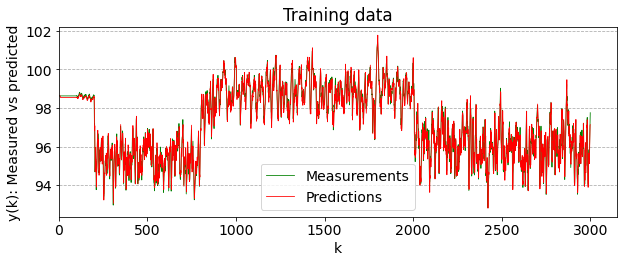

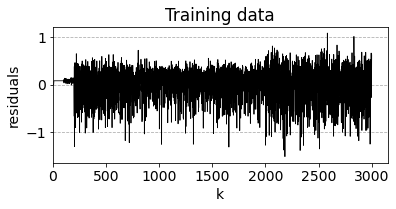

In [9]:
# get model predictions and residuals on training dataset
y_fit_predicted_centered = model.predict(X=u_fit_centered, y=y_fit_centered, steps_ahead=1)
y_fit_predicted = y_scaler.inverse_transform(y_fit_predicted_centered)
residuals_fit = y_fit - y_fit_predicted

plt.figure(figsize=(10,3.5)), plt.plot(y_fit, 'g', linewidth=0.8, label='Measurements'), plt.plot(y_fit_predicted, 'r', linewidth=0.8, label='Predictions')
plt.title('Training data'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,2.5)), plt.plot(residuals_fit, 'black', linewidth=0.8)
plt.title('Training data'), plt.ylabel('residuals'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

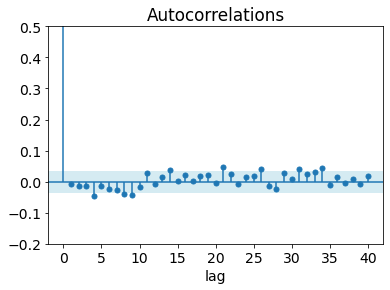

In [10]:
# ACF of residuals
conf_int = 1.96/np.sqrt(len(residuals_fit))

plot_acf(residuals_fit, lags= 40, alpha=None, title='')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # integer xtick labels
plt.xlabel('lag'), plt.title('Autocorrelations'), plt.ylim(-0.2, 0.5) 
plt.show()
plt.show()

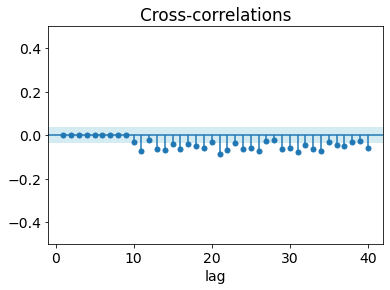

In [11]:
# CCF b/w residuals and input sequence
ccf_vals = ccf(residuals_fit, u_fit, adjusted=False) # ccf for lag > 0
ccf_vals = ccf_vals[1:41] # ccf for lag 1 to 20

# generate CCF plot
lags = np.arange(1,41)

plt.figure(figsize=(6,4)), plt.vlines(lags, [0], ccf_vals), plt.axhline(0, 0, lags[-1])
plt.plot(lags, ccf_vals, marker='o', markersize=5, linestyle='None')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.xlabel('lag'), plt.title('Cross-correlations')
plt.ylim(-0.5, 0.5)
plt.show()

In [10]:
#%% %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##               m-step ahead predictions on test dataset
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

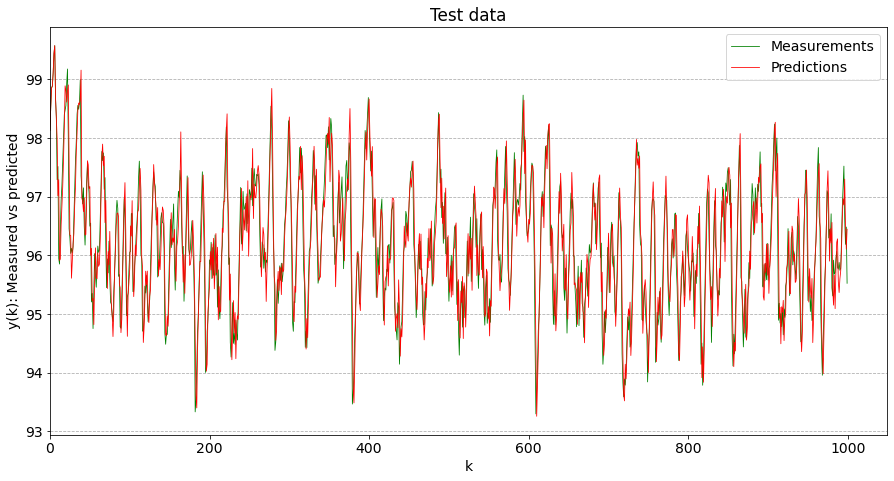

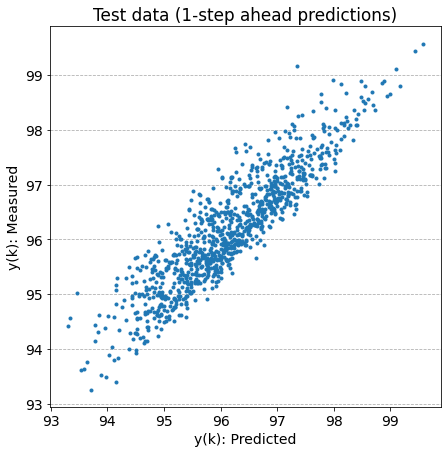

In [12]:
# #%% 1-step ahead predictions
y_test_predicted_centered = model.predict(X=u_test_centered, y=y_test_centered, steps_ahead=1)
y_test_predicted = y_scaler.inverse_transform(y_test_predicted_centered)

plt.figure(figsize=(15,7.5)), plt.plot(y_test, 'g', linewidth=0.8, label='Measurements'), plt.plot(y_test_predicted, 'r', linewidth=0.8, label='Predictions')
plt.title('Test data'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(7,7)), plt.plot(y_test, y_test_predicted, '.', linewidth=0.8)
plt.title('Test data (1-step ahead predictions)'), plt.ylabel('y(k): Measured'), plt.xlabel('y(k): Predicted')
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

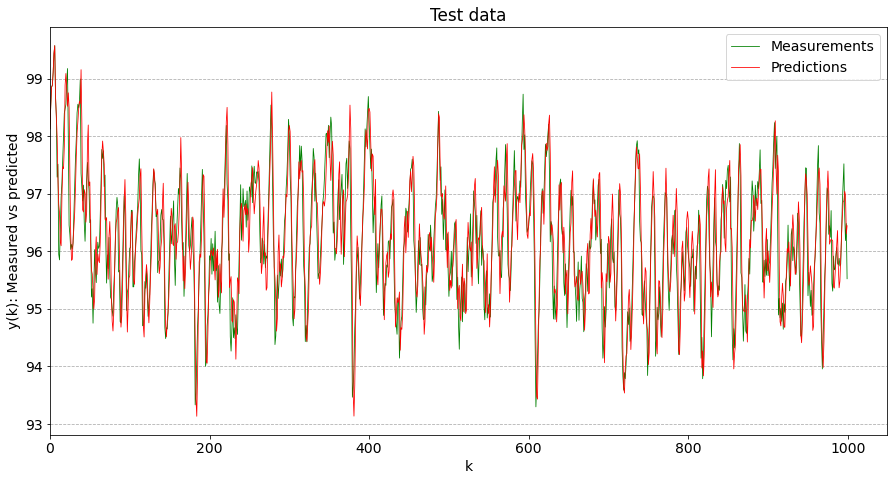

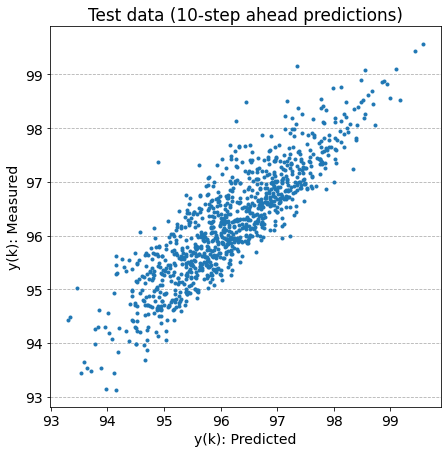

In [13]:
# 10-step ahead predictions
y_test_predicted_centered = model.predict(X=u_test_centered, y=y_test_centered, steps_ahead=10)
y_test_predicted = y_scaler.inverse_transform(y_test_predicted_centered)

plt.figure(figsize=(15,7.5)), plt.plot(y_test, 'g', linewidth=0.8, label='Measurements'), plt.plot(y_test_predicted, 'r', linewidth=0.8, label='Predictions')
plt.title('Test data'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(7,7)), plt.plot(y_test, y_test_predicted, '.', linewidth=0.8)
plt.title('Test data (10-step ahead predictions)'), plt.ylabel('y(k): Measured'), plt.xlabel('y(k): Predicted')
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

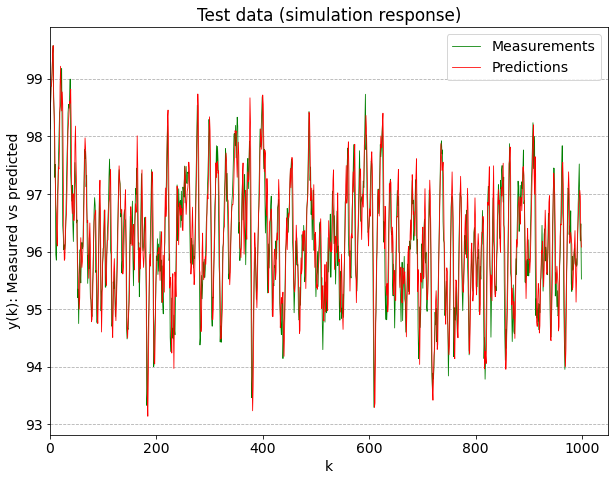

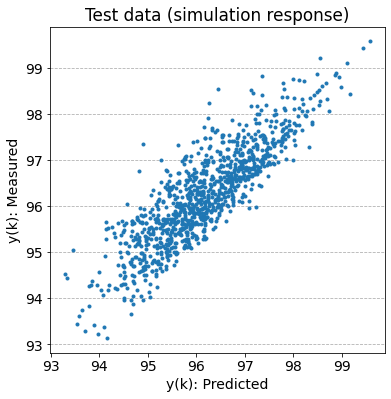

In [14]:
# infinite-step ahead predictions
y_test_predicted_centered = model.predict(X=u_test_centered, y=y_test_centered, steps_ahead=None)
y_test_predicted = y_scaler.inverse_transform(y_test_predicted_centered)

plt.figure(figsize=(10,7.5)), plt.plot(y_test, 'g', linewidth=0.8, label='Measurements'), plt.plot(y_test_predicted, 'r', linewidth=0.8, label='Predictions')
plt.title('Test data (simulation response)'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,6)), plt.plot(y_test, y_test_predicted, '.', linewidth=0.8)
plt.title('Test data (simulation response)'), plt.ylabel('y(k): Measured'), plt.xlabel('y(k): Predicted')
plt.grid(which='both', axis='y', linestyle='--')
plt.show()